In [1]:
%%capture
import numpy as np
import pandas as pd
!pip install openpyxl
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import os
import matplotlib.pyplot as plt
import matplotlib

In [2]:
actual_path = os.getcwd()
os.chdir('/home/onyxia/work/material_science/Spetral_clustering')
%run rbf.ipynb
os.chdir(actual_path)

In [3]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
list_elements_failed = list(list_failed['MAX'])
n_samples = max_elemental.shape[0]
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
max_calculated = max_calculated.set_index('prettyformula',drop=True)
whole_data = max_elemental.merge(max_calculated,how='inner',
                                 left_index=True,right_index=True)
whole_data = whole_data.drop(['PU_label','year'],axis=1)
M_elements = pd.get_dummies(whole_data['M'],prefix='M',dtype=float)
A_elements = pd.get_dummies(whole_data['A'],prefix='A',dtype=float)
X_elements = pd.get_dummies(whole_data['X'],prefix='X',dtype=float)
whole_data = whole_data.drop(['M','A','X'],axis=1)
x_group = pd.get_dummies(whole_data['X_X_group'],prefix='x_g',dtype=float)
a_group = pd.get_dummies(whole_data['A_A_group'],prefix='a_g',dtype=float)
m_group = pd.get_dummies(whole_data['M_M_group'],prefix='m_g',dtype=float)
whole_data = whole_data.drop(['X_X_group','A_A_group','M_M_group'],axis=1)
whole_data = pd.concat([whole_data,M_elements,A_elements,X_elements,x_group,
                       a_group,m_group],axis=1)
number_of_atoms = np.zeros(n_samples)
compteur = 0
for element in whole_data.index:
    inter = []
    for cara in element:
        if cara in list(str(1234567890)):
            inter.append(cara)
    if len(inter) == 1:
        number_of_atoms[compteur] = int(inter[0]) + 2
    elif len(inter) == 2:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + 1
    elif len(inter) == 3:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + int(inter[2])
    compteur += 1

columns_name = whole_data.drop(['class'],axis=1).columns.copy()
normalized = whole_data.drop(['class'],axis=1).to_numpy()/number_of_atoms.reshape(-1,1)

data_norm = pd.DataFrame(normalized)
data_norm.columns = columns_name
data_norm['compound_name'] = whole_data.index
data_norm = data_norm.set_index('compound_name',drop=True)


data_norm['class'] = whole_data['class'].copy()

diff_z = list(data_norm.columns)
retained_features = list(data_norm.columns)

for feat in diff_z:
    if len(feat) > 5:
        retained_features.remove(feat)

list_dummies = []

for i in retained_features:
    if 'M_' in i:
        list_dummies.append(i)
    elif 'A_' in i:
        list_dummies.append(i)
    elif 'X_' in i:
        list_dummies.append(i)
    elif 'x_g' in i:
        list_dummies.append(i)
    elif 'a_g' in i:
        list_dummies.append(i)
    elif 'm_g' in i:
        list_dummies.append(i)

for col in list_dummies:
    for row in data_norm.index:
        if data_norm.loc[row,col] != 0:
            data_norm.loc[row,col] = 1

In [4]:
positive_instances = data_norm[data_norm['class'] == 1]
index_of_positive = list(positive_instances.index)
unlabelled_instances = data_norm.drop(labels=index_of_positive,axis=0)

In [5]:
n_positives = positive_instances.shape[0]

In [6]:
t=15

In [7]:
df_results = data_norm.drop(list(data_norm.columns),axis=1)

In [8]:
for i in range(t):
    u_t = unlabelled_instances.sample(n=n_positives)
    training_set = pd.concat([positive_instances,u_t])
    training_index = list(training_set.index)
    clf = SVC().fit(X=training_set.drop(['class'],axis=1).to_numpy(),y=training_set['class'].to_numpy())
    interm_df = data_norm.drop(labels=training_index,axis=0)
    interm_df['predictions'] = clf.decision_function(X=interm_df.drop(['class'],axis=1).to_numpy())
    df_for_merge = pd.DataFrame(interm_df['predictions'])
    df_for_merge.columns = [f'score_{i}']
    df_results = df_results.merge(df_for_merge, how='left', left_index=True, right_index=True) 

In [9]:
results_df = pd.DataFrame(df_results.mean(axis=1))

In [10]:
results_df.columns = ['score_bagging']

In [11]:
results_df = results_df.sort_values(by='score_bagging', ascending=False)
whole_results = results_df.copy()

In [12]:
results_df = results_df.head(100)
results_df = results_df.reset_index()
results_df['rank_bagging'] = results_df.index
results_df = results_df.set_index(keys='compound_name',drop=True)

In [13]:
results_df.to_csv('ordered_predictions_bagging_svm_15_all_features.csv')

In [14]:
df_to_plot = max_calculated.filter(items=list(results_df.index),axis=0)
df_to_plot = df_to_plot.filter(items=['dEf','dH'],axis=1)

df_no_pos = max_calculated.drop(labels=list(results_df.index),axis=0)
df_no_pos = df_no_pos.filter(items=['dEf','dH'],axis=1)

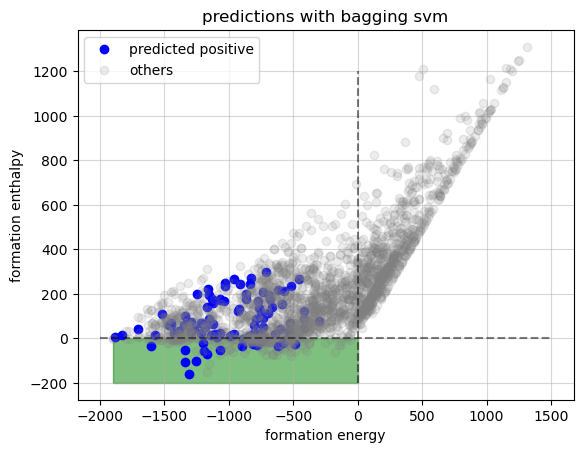

In [30]:
fig, ax = plt.subplots()

ax.plot(df_to_plot['dEf'].to_numpy(),df_to_plot['dH'].to_numpy(),'bo',
         label='predicted positive')
ax.plot(df_no_pos['dEf'].to_numpy(),df_no_pos['dH'].to_numpy(),'o',color='gray',alpha=0.15,
         label='others')
ax.plot(np.linspace(-2000,1500,2,endpoint=True),np.zeros(2),'--k',alpha=0.5)
ax.plot(np.zeros(2),np.linspace(-200,1200,2,endpoint=True),'--k',alpha=0.5)
ax.fill_between(np.linspace(np.min(df_no_pos['dEf'].to_numpy()),0,2,endpoint=True),y1=-200,y2=0,color='green',alpha=0.5)
ax.grid(alpha=0.5)
ax.set_xlabel(xlabel='formation energy')
ax.set_ylabel(ylabel='formation enthalpy')
ax.set_title('predictions with bagging svm')
plt.legend()
plt.savefig('bagging_svm_predictions.png')

In [16]:
whole_results = whole_results.drop(list(positive_instances.index),axis=0)

In [17]:
df_tree = whole_results.merge(right=data_norm,how='left',left_index=True,
                              right_index=True)

In [18]:
df_tree = df_tree.drop(['class'],axis=1)
df_tree['class'] = np.sign(df_tree['score_bagging'])

In [19]:
whole_results['color'] = ['salmon']*whole_results.shape[0]

In [20]:
#lightsteelblue salmon

In [21]:
for elem in whole_results.index:
    if elem in list_elements_failed:
        whole_results.loc[elem,'color'] = 'darkred'
    elif whole_results.loc[elem,'score_bagging']>0:
        whole_results.loc[elem,'color'] = 'lightsteelblue'

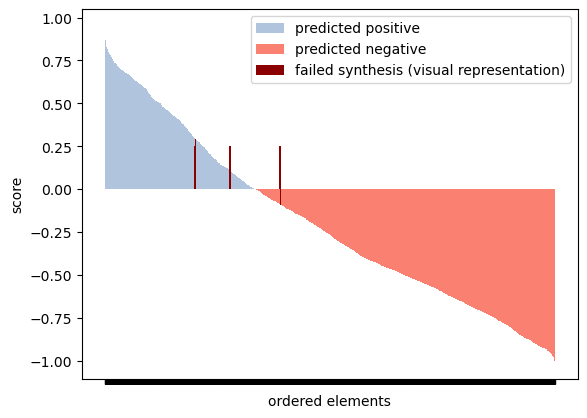

In [22]:
fig, ax = plt.subplots()
ax.bar(x=['Zr2SN','Zr2SN','Zr2SN'], height=[0,0,0],
       color=['lightsteelblue','salmon', 'darkred'],label=['predicted positive','predicted negative',
                                                'failed synthesis (visual representation)'])
ax.bar(x=whole_results.index,height=whole_results['score_bagging'],color=whole_results['color'],
      align='edge',width=1)
ax.bar(x=list_elements_failed,height=0.25,width=10,color=['darkred','darkred','darkred'])
ax.set(xticklabels=[])
ax.set(ylabel='score')
ax.set(xlabel='ordered elements')
ax.legend()
plt.savefig('bagging_element_score.png')

In [23]:
tree_for_imp = RandomForestClassifier(n_estimators=1000).fit(X=df_tree.drop(['score_bagging','class'],axis=1),
                                                           y=df_tree['class'])

In [24]:
df_imp_feat = pd.DataFrame(tree_for_imp.feature_importances_)

In [25]:
df_imp_feat.index = df_tree.drop(['score_bagging','class'],axis=1).columns
df_imp_feat.columns = ['score_imp_feat']
df_imp_feat = df_imp_feat.sort_values(by='score_imp_feat',ascending=False)

In [26]:
df_imp_feat['color'] = ['cornflowerblue']*df_imp_feat.shape[0]
df_imp_feat.loc['dH','color'] = 'lightcoral'
df_imp_feat.loc['dEf','color'] = 'lightcoral'

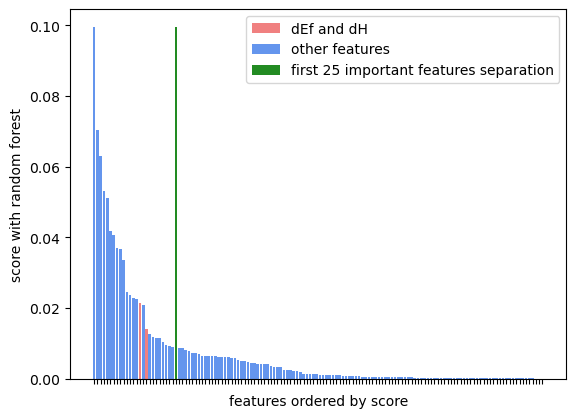

In [27]:
first_features = df_imp_feat.index[25]
fig, ax = plt.subplots()
ax.bar(x=df_imp_feat.index,
       height=df_imp_feat['score_imp_feat'],color=df_imp_feat['color'])
ax.set(xticklabels=[])
ax.bar(first_features,height=np.max(df_imp_feat['score_imp_feat']),color='forestgreen',
       label='first 25 important features separation')
ax.set(ylabel='score with random forest')
ax.set(xlabel='features ordered by score')
ax.bar(x=['0','0'],height=[0,0],color=['lightcoral','cornflowerblue'],label=['dEf and dH', 'other features'])
ax.legend()
plt.savefig('features_imp_bagging.png')

In [28]:
print(df_imp_feat.drop(['color'],axis=1).head(25).to_latex())

\begin{tabular}{lr}
\toprule
 & score_imp_feat \\
\midrule
dEc & 0.099548 \\
dMX & 0.070323 \\
dMM & 0.062982 \\
e_X & 0.053202 \\
e_M & 0.051195 \\
M_M_average_cationic_radius & 0.041730 \\
M_M_average_ionic_radius & 0.040635 \\
E_pa & 0.037081 \\
M_M_atomic_radius_calculated & 0.036648 \\
M_M_van_der_waals_radius & 0.033700 \\
M_M_atomic_radius & 0.024597 \\
rMA & 0.023632 \\
a & 0.022806 \\
rMX & 0.022500 \\
dEf & 0.021342 \\
e_A & 0.020979 \\
dH & 0.014000 \\
M_M_second_ionization_energy & 0.012567 \\
A_A_second_ionization_energy & 0.011734 \\
dMA & 0.011496 \\
M_M_first_ionization_energy & 0.011404 \\
A_A_van_der_waals_radius & 0.010248 \\
M_M_electronegativity & 0.009607 \\
volume.pa & 0.009212 \\
A_A_average_cationic_radius & 0.009095 \\
\bottomrule
\end{tabular}



In [29]:
df_to_plot.to_csv('convertible_bagging.csv')

In [33]:
print(whole_results.sort_values(by='score_bagging', ascending=False).drop(['color'],axis=1).head(25).to_latex())

\begin{tabular}{lr}
\toprule
 & score_bagging \\
compound_name &  \\
\midrule
Zr2SC & 0.951208 \\
Zr2SN & 0.927032 \\
Zr2PN & 0.900481 \\
Hf2SC & 0.887134 \\
Ti2SN & 0.866732 \\
Ti2IrN & 0.865687 \\
Zr2SeC & 0.865495 \\
Zr2PC & 0.858486 \\
Sc2SN & 0.833642 \\
Hf2SN & 0.830373 \\
Hf2PN & 0.829784 \\
Ti2PN & 0.824147 \\
Hf2PC & 0.821369 \\
Zr2SeN & 0.819288 \\
Ti2RhN & 0.818127 \\
Ti2OsN & 0.808461 \\
Hf2SeC & 0.806952 \\
Ti2RuN & 0.803554 \\
Zr2AsN & 0.797571 \\
Ti2SiN & 0.796927 \\
Ti2PtN & 0.794911 \\
Ti2PC & 0.793858 \\
Sc2SC & 0.793855 \\
Zr2IrN & 0.793367 \\
Zr2RhN & 0.788567 \\
\bottomrule
\end{tabular}

